<a href="https://colab.research.google.com/github/derrionrobinson/Machine-Learning-Final-Project/blob/main/Final_Project_%5BMachine_Learning%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from pandas.api.types import is_numeric_dtype
from sklearn.compose import ColumnTransformer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F


In [ ]:
#Logistic Regression Model

url ='https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/Loan_default.csv'
LoanDefault = pd.read_csv(url)
print(LoanDefault.head())


#Preprocessing
print(LoanDefault.info())

missing_values = LoanDefault.isnull().sum()
print(missing_values)

print(LoanDefault['HasCoSigner'].unique())
print(LoanDefault['Education'].unique())
print(LoanDefault['EmploymentType'].unique())
print(LoanDefault['MaritalStatus'].unique())
print(LoanDefault['HasMortgage'].unique())
print(LoanDefault['HasDependents'].unique())
print(LoanDefault['LoanPurpose'].unique())

# Binary Conversion
cosigner_conversion = ['HasCoSigner']
LoanDefault[cosigner_conversion] = LoanDefault[cosigner_conversion].replace({'Yes': 1, 'No': 0})

employement_conversion = ['EmploymentType']
LoanDefault[employement_conversion] = LoanDefault[employement_conversion].replace({'Full-time':1, 'Unemployed':0, 'Self-employed':1, 'Part-time':1})

marital_conversion = ['MaritalStatus']
LoanDefault[marital_conversion] = LoanDefault[marital_conversion].replace({'Divorced':0, 'Married':1, 'Single':0})

education_conversion = ['Education']
LoanDefault[education_conversion] = LoanDefault[education_conversion].replace({'High School': 0, "Bachelor's": 1, "Master's": 1, "PhD": 1})

mortgage_conversion = ['HasMortgage']
LoanDefault[mortgage_conversion] = LoanDefault[mortgage_conversion].replace({'Yes': 1, 'No': 0})

dependents_conversion = ['HasDependents']
LoanDefault[dependents_conversion] = LoanDefault[dependents_conversion].replace({'Yes': 1, 'No': 0})

print(LoanDefault.head())

print(LoanDefault.dtypes)


#Training and testing sets
explanatory_variables = LoanDefault.drop(columns=['LoanID', 'LoanPurpose'])
ground_truth = LoanDefault['Default']

explanatory_train, explanatory_test, ground_truth_train, ground_truth_test = train_test_split(
    explanatory_variables, ground_truth, test_size=0.20, random_state=0
)

#Standardization
scaler = StandardScaler()
explanatory_variables = scaler.fit_transform(explanatory_variables)

#Logistic Regression Model
log_reg_model = LogisticRegression(
    solver='saga',
    max_iter=1000,
    warm_start=True,
    class_weight='balanced',
    penalty='l2',
    C=1.0,
    random_state=42
)

log_reg_model.fit(explanatory_train, ground_truth_train)

# Predictions
ground_truth_pred = log_reg_model.predict(explanatory_test)
ground_truth_proba = log_reg_model.predict_proba(explanatory_test)[:, 1]

# Metrics
accuracy = metrics.accuracy_score(ground_truth_test, ground_truth_pred)
precision = metrics.precision_score(ground_truth_test, ground_truth_pred)
recall = metrics.recall_score(ground_truth_test, ground_truth_pred)
f1_score = metrics.f1_score(ground_truth_test, ground_truth_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
print("Final Testing Log Loss:", log_loss(ground_truth_test, ground_truth_proba))

# Confusion Matrix Output
conf_matrix = confusion_matrix(ground_truth_test, ground_truth_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu", fmt='g',
            xticklabels=['No Default (0)', 'Default (1)'], yticklabels=['No Default (0)', 'Default (1)'])
plt.title('Confusion Matrix', y=1.05)
plt.ylabel('Actual (Ground Truth)')
plt.xlabel('Predicted')
plt.show()

# 1. Training Loss
train_proba = log_reg_model.predict_proba(explanatory_train)[:, 1]
train_loss = log_loss(ground_truth_train, train_proba)

# 2. Testing Loss
test_proba = log_reg_model.predict_proba(explanatory_test)[:, 1]
test_loss = log_loss(ground_truth_test, test_proba)

print(f"Training Loss: {train_loss:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

# --- 8. Visualization of Performance Metrics ---
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1_score]

plt.figure(figsize=(9, 5))
bar_plot = plt.bar(metrics_names, metrics_values, color=['#4daf4a', '#377eb8', '#ff7f00', '#984ea3'])
plt.ylim(0.0, 1.0) # Metrics are always between 0 and 1
plt.title('Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

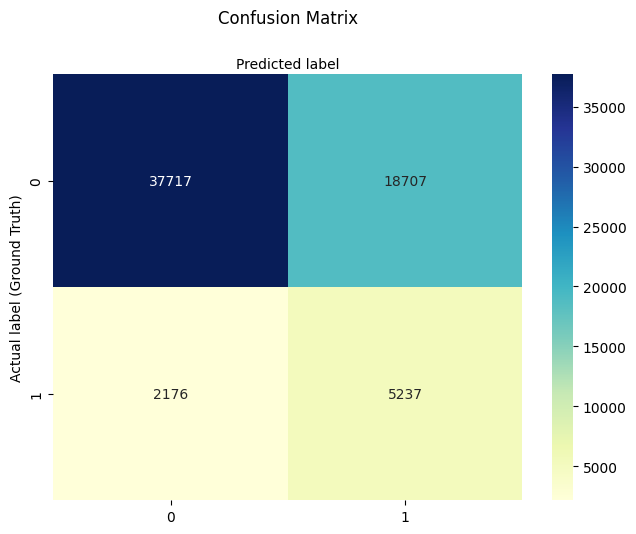

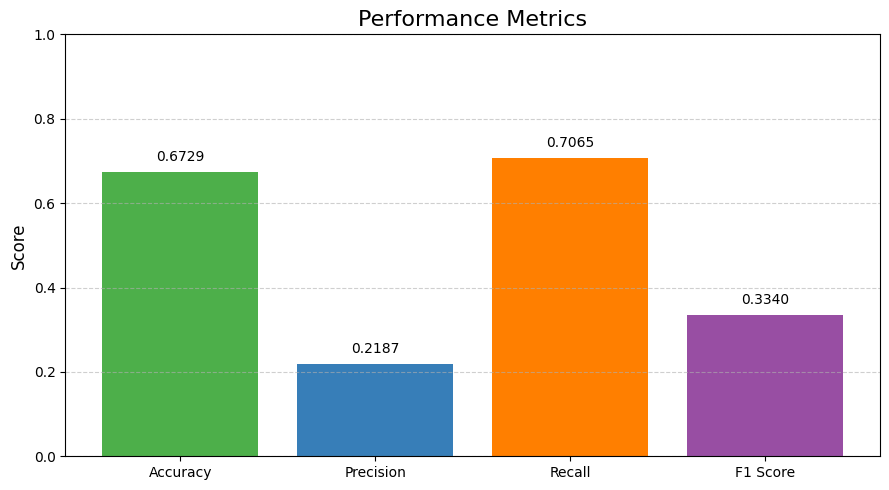

In [3]:
# SVM Model
url ='https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/Loan_default.csv'
df = pd.read_csv(url)



# Remove ID-like columns
id_like = [col for col in df.columns if 'id' in col.lower()]
df = df.drop(columns=id_like)

# Fill missing values
for col in df.columns:
    if is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

# Encode categorical columns
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le


target = "Default"
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


model = LinearSVC(class_weight="balanced", max_iter=5000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

# Visualization
class_labels = [0, 1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels)
plt.yticks(tick_marks, class_labels)

# Confusion Matrix Output
sns.heatmap(pd.DataFrame(conf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.ylabel('Actual label (Ground Truth)')
plt.xlabel('Predicted label')
plt.show()


accuracy  = accuracy_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)

# --- 8. Visualization of Performance Metrics ---
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
metrics_values = [accuracy, precision, recall, f1]

plt.figure(figsize=(9, 5))
bar_plot = plt.bar(metrics_names, metrics_values, color=['#4daf4a', '#377eb8', '#ff7f00', '#984ea3'])
plt.ylim(0.0, 1.0) # Metrics are always between 0 and 1
plt.title('Performance Metrics', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
# FCNN Model

"""
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Load and preprocess data

df = pd.read_csv("https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/Loan_default.csv") # Change this path

X = df.drop(["Default", "LoanID"], axis=1)
y = df["Default"].astype(int)

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_proc = preprocess.fit_transform(X)
if hasattr(X_proc, "todense"):
    X_proc = X_proc.todense()
X_proc = np.array(X_proc)

# Train / Val / Test split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_proc, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.1, random_state=42, stratify=y_train_full
)

# Convert to tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values,   dtype=torch.long)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values,  dtype=torch.long)

# Loaders
train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=256, shuffle=False)

print("Dataset sizes -> Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(y_test))

# Focal Loss (reducing FP + FN on hard samples)
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=3.0, reduction="mean"):
        super().__init__()
        if alpha is not None:
            self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
        else:
            self.alpha = None
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        ce = F.cross_entropy(logits, target, reduction="none")
        pt = torch.exp(-ce)

        if self.alpha is not None:
            at = self.alpha[target]
            ce = at * ce

        fl = (1 - pt) ** self.gamma * ce
        return fl.mean() if self.reduction == "mean" else fl.sum()

#  Neural Network Architecture
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = SimpleNet(input_dim).to(device)

#  Class weights to reduce FN imbalance
counts = np.bincount(y_train)
neg, pos = counts[0], counts[1]
pos_weight = 3.0   # LOWER pos_weight reduces FP
class_weights = torch.tensor([1.0, pos_weight], dtype=torch.float32).to(device)
print("Class weights used:", class_weights.tolist())

criterion = FocalLoss(alpha=class_weights, gamma=3.0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

#  Training loop with Early Stopping (Val F1)
epochs = 40
patience = 5
best_val_f1 = -1
best_state = None
epochs_no_improve = 0

for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    all_probs, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:, 1]
            all_probs.extend(probs.cpu().numpy())
            all_true.extend(yb.numpy())

    val_preds = (np.array(all_probs) > 0.5).astype(int)
    val_f1 = f1_score(all_true, val_preds, zero_division=0)
    print(f"Epoch {epoch+1}  Val F1={val_f1:.3f}")

    # Early stopping
    if val_f1 > best_val_f1 + 1e-4:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping activated.")
            break

model.load_state_dict(best_state)

# Compute test probabilities
model.eval()
with torch.no_grad():
    logits_test = model(X_test_t.to(device))
    probs_test = torch.softmax(logits_test, dim=1)[:, 1].cpu().numpy()

# LOW-FP Operating Threshold
thresholds = np.linspace(0.2, 0.9, 36)

best_fp = float("inf")
best_thr = None
best_stats = None

print("\nthr     FP     FN    Prec   Rec   F1")
print("-----------------------------------------")

for thr in thresholds:
    preds = (probs_test > thr).astype(int)
    cm = confusion_matrix(y_test, preds)
    tn, fp, fn, tp = cm.ravel()

    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)

    # Only consider thresholds with decent recall
    if rec >= 0.25 and fp < best_fp:
        best_fp = fp
        best_thr = thr
        best_stats = (cm, prec, rec, f1)

    print(f"{thr:0.3f} {fp:6d} {fn:6d}  {prec:0.3f} {rec:0.3f} {f1:0.3f}")

cm, prec, rec, f1 = best_stats
tn, fp, fn, tp = cm.ravel()

print("\n===== LOW-FP OPTIMIZED MODEL =====")
print("Threshold:", best_thr)
print("Precision:", prec)
print("Recall   :", rec)
print("F1 Score :", f1)
print("Confusion Matrix:\n", cm)
print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Default (Pred)", "Default (Pred)"],
            yticklabels=["No Default (Actual)", "Default (Actual)"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Using device: cpu
Dataset sizes -> Train: 183849 Val: 20428 Test: 51070
Class weights used: [1.0, 3.0]


/tmp/ipython-input-1197727689.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))


Epoch 1  Val F1=0.337


KeyboardInterrupt: 

Baseline F1: 0.3323921721351378


/tmp/ipython-input-596326678.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(20), x="Importance", y="Feature", palette="Blues_r")


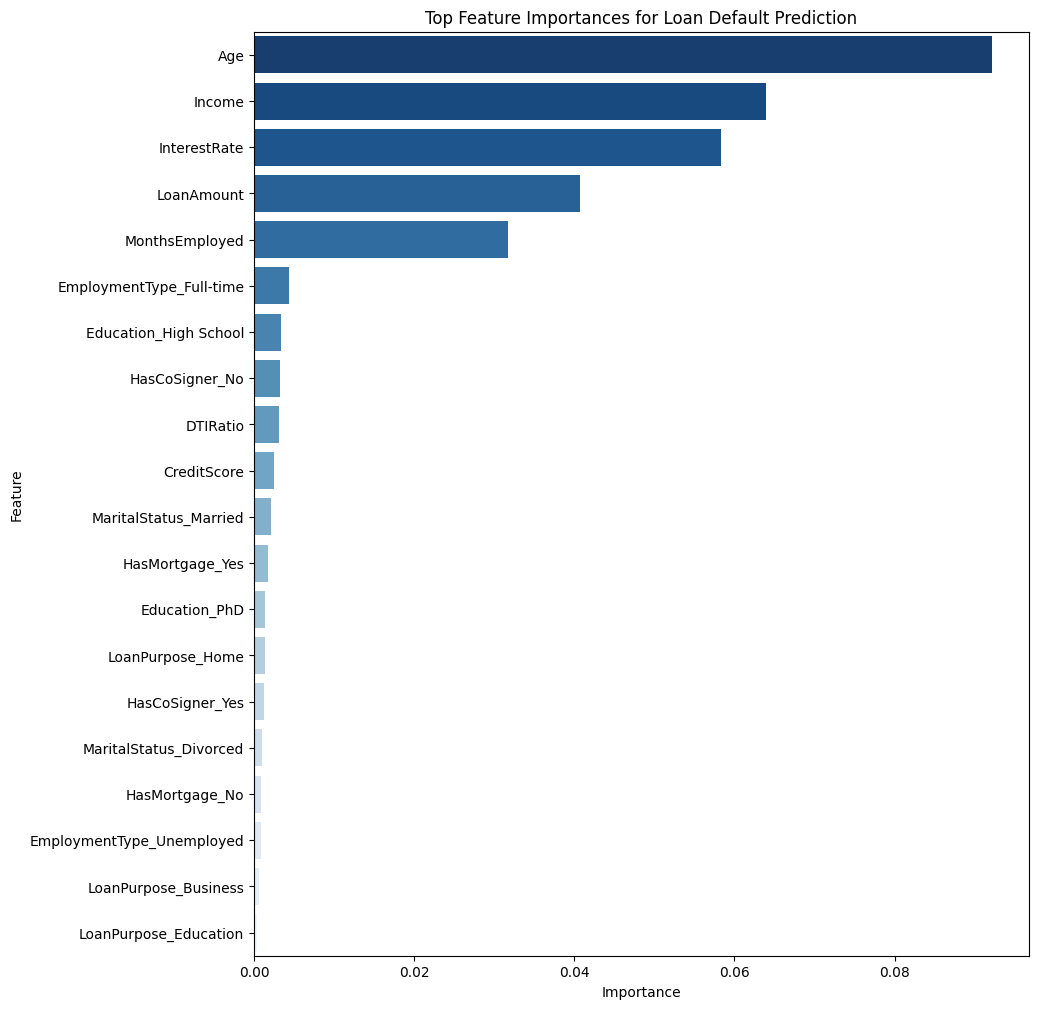

,Feature,Importance
0,Age,0.092177
1,Income,0.063928
6,InterestRate,0.058329
2,LoanAmount,0.040666
4,MonthsEmployed,0.031736
13,EmploymentType_Full-time,0.004334
10,Education_High School,0.003417
29,HasCoSigner_No,0.003258
8,DTIRatio,0.003114
3,CreditScore,0.002546


In [ ]:
#FCNN Prediction Importance chart

def permutation_importance(model, X_test, y_test, preprocess, device, repeats=3):

    # Get baseline F1
    with torch.no_grad():
        logits = model(torch.tensor(X_test, dtype=torch.float32).to(device))
        base_probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
    base_preds = (base_probs > 0.5).astype(int)
    base_f1 = f1_score(y_test, base_preds)

    print("Baseline F1:", base_f1)

    importances = []

    X_test_original = X_test.copy()

    # Loop over each feature column
    for col in range(X_test.shape[1]):
        f1_scores = []

        for _ in range(repeats):
            X_shuffled = X_test_original.copy()
            np.random.shuffle(X_shuffled[:, col])  # destroy signal

            with torch.no_grad():
                logits = model(torch.tensor(X_shuffled, dtype=torch.float32).to(device))
                probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
            preds = (probs > 0.5).astype(int)
            f1_scores.append(f1_score(y_test, preds))

        importance = base_f1 - np.mean(f1_scores)
        importances.append(importance)

    return np.array(importances)


importances = permutation_importance(model, X_test, y_test, preprocess, device)

feature_names = (
    list(num_cols) +
    list(preprocess.named_transformers_['cat'].get_feature_names_out(cat_cols))
)

imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=imp_df.head(20), x="Importance", y="Feature", palette="Blues_r")
plt.title("Top Feature Importances for Loan Default Prediction")
plt.show()

imp_df.head(20)

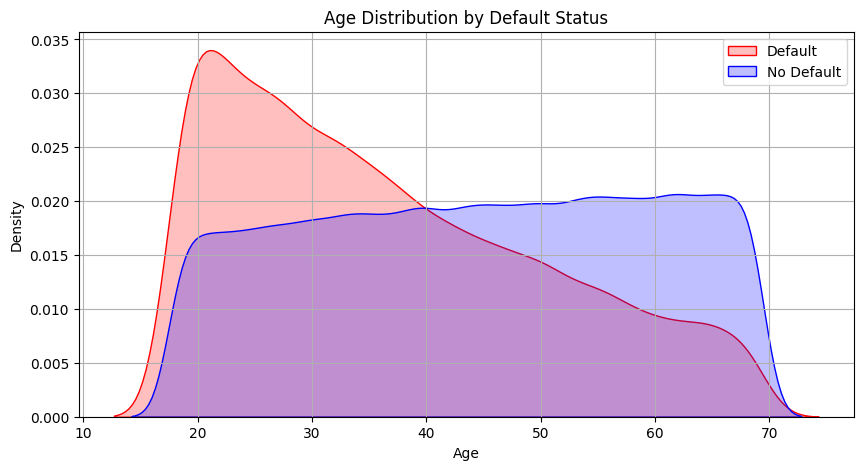

/tmp/ipython-input-1557725402.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_default = df.groupby("AgeBucket")["Default"].mean()


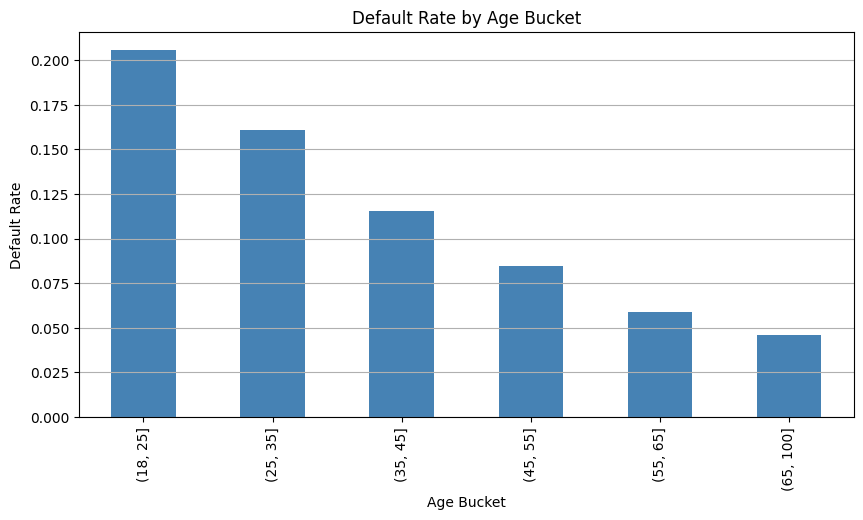

,Default
AgeBucket,
"(18, 25]",0.205555
"(25, 35]",0.160784
"(35, 45]",0.115482
"(45, 55]",0.084500
"(55, 65]",0.058598
"(65, 100]",0.046019


In [ ]:
#FCNN Age Graph

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/Loan_default.csv")

# Clean and convert Age
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")
df = df.dropna(subset=["Age"])

# --- Age KDE Plot ---
plt.figure(figsize=(10,5))
sns.kdeplot(data=df[df["Default"]==1], x="Age", label="Default", fill=True, color="red")
sns.kdeplot(data=df[df["Default"]==0], x="Age", label="No Default", fill=True, color="blue")
plt.title("Age Distribution by Default Status")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# --- Age Bucket Bar Chart ---
df["AgeBucket"] = pd.cut(df["Age"], bins=[18,25,35,45,55,65,100])
age_default = df.groupby("AgeBucket")["Default"].mean()

plt.figure(figsize=(10,5))
age_default.plot(kind="bar", color="steelblue")
plt.title("Default Rate by Age Bucket")
plt.ylabel("Default Rate")
plt.xlabel("Age Bucket")
plt.grid(axis='y')
plt.show()

age_default


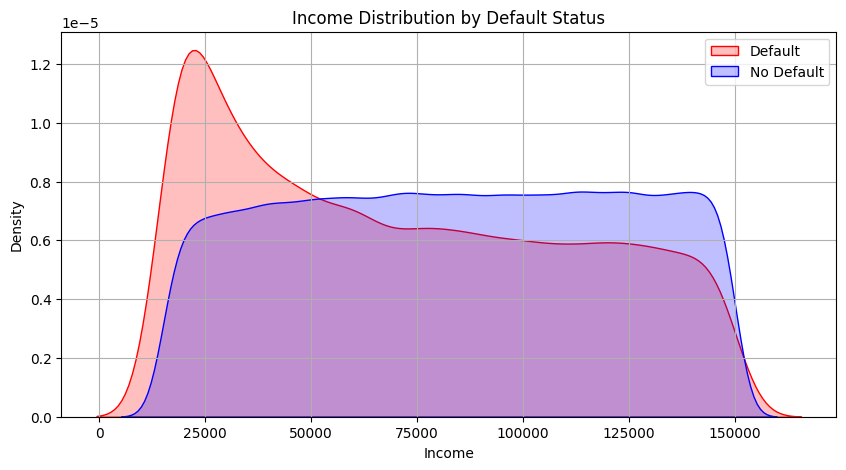

/tmp/ipython-input-1684806632.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_default = df.groupby("IncomeBucket")["Default"].mean()


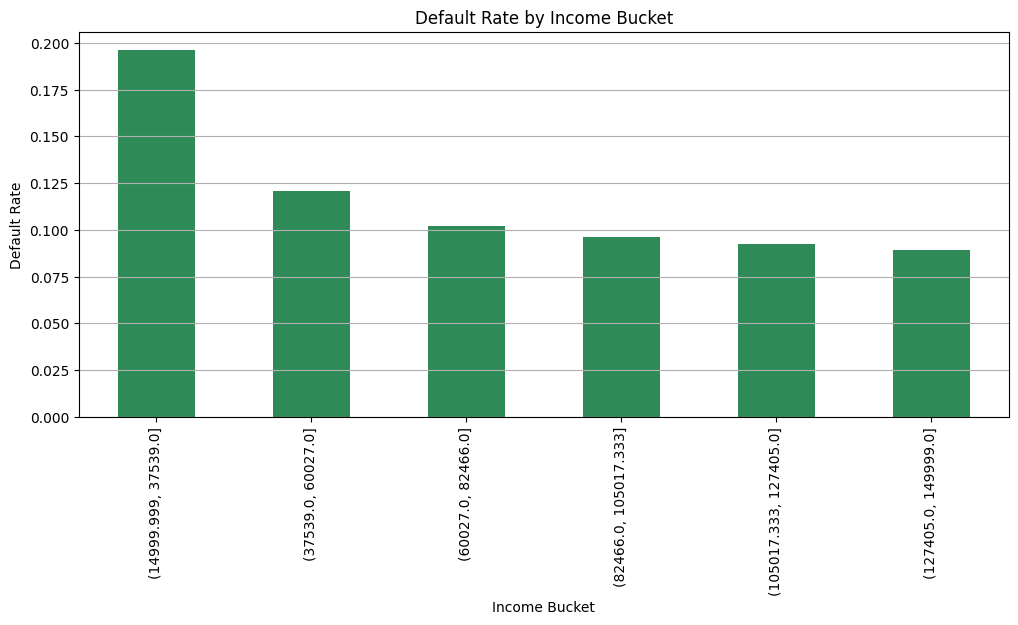

,Default
IncomeBucket,
"(14999.999, 37539.0]",0.196109
"(37539.0, 60027.0]",0.120680
"(60027.0, 82466.0]",0.101981
"(82466.0, 105017.333]",0.096294
"(105017.333, 127405.0]",0.092479
"(127405.0, 149999.0]",0.089226


In [ ]:
#FCNN Income Graph

# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/derrionrobinson/Machine-Learning-Practice/refs/heads/main/Loan_default.csv")

# Clean Income column
df["Income"] = pd.to_numeric(df["Income"], errors="coerce")
df = df.dropna(subset=["Income"])

# Clean Default column just in case
df["Default"] = pd.to_numeric(df["Default"], errors="coerce")
df = df.dropna(subset=["Default"])

# --- Income KDE Plot ---
plt.figure(figsize=(10,5))
sns.kdeplot(df[df["Default"]==1]["Income"], label="Default", fill=True, color="red")
sns.kdeplot(df[df["Default"]==0]["Income"], label="No Default", fill=True, color="blue")
plt.title("Income Distribution by Default Status")
plt.xlabel("Income")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

# --- Income Bucket Bar Chart ---
# Use quantile-based buckets for better separation
df["IncomeBucket"] = pd.qcut(df["Income"], q=6, duplicates="drop")

income_default = df.groupby("IncomeBucket")["Default"].mean()

plt.figure(figsize=(12,5))
income_default.plot(kind="bar", color="seagreen")
plt.title("Default Rate by Income Bucket")
plt.ylabel("Default Rate")
plt.xlabel("Income Bucket")
plt.grid(axis='y')
plt.show()

income_default